In [1]:
import pandas as pd
import numpy as np
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves accessibility attribute to PT LoS table
## Needs PT LoS table, links and distance clusters

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
los = stepmodel.read_json(model_path + 'de_pt_los')

In [4]:
sm.pt_los = los.pt_los

In [5]:
def accessibility(dist_origin, dist_destination, weight=20):
    '''calculate an accessibility metric based on distances
    :param dist_origin: distance to the next mean of transport from origin in km
    :param dist_destination: distance from the used mean of transport to destination in km
    :param weight: (optional) weight of distance values
    :return: accessibility factor on a range from 0 to 1'''
    return max(0, 1 - dist_origin/weight - dist_destination/weight)

In [6]:
# Take average weighted distances to the next PT stop
# They were computed in prep22 from census data
clusters = pd.read_csv(input_path + 'spatial_census_refined.csv')
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
# Convert to km
clusters[mean_dist_col] = clusters[mean_dist_col] / 1000

route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

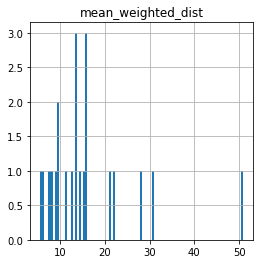

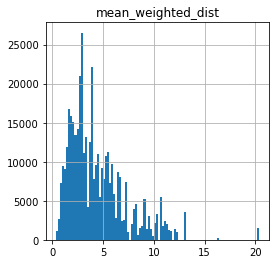

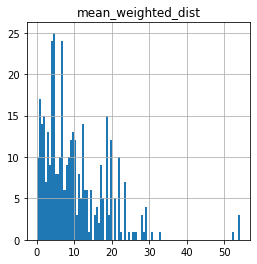

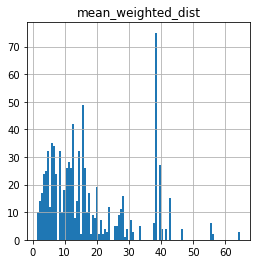

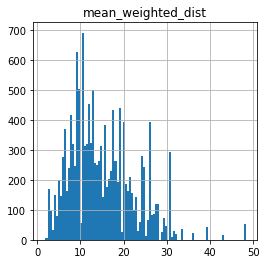

In [7]:
clusters.groupby('route_type').hist(column=mean_dist_col, bins=100, figsize=(4,4))

In [8]:
mean_w_dist_dict = clusters.groupby(
    ['NUTS_ID', 'route_type']).agg(
    {mean_dist_col: 'mean'}).to_dict()[mean_dist_col]

In [9]:
# The accessibility is a metric from the mean weighted distance in km
sm.pt_los['accessibility'] = 1

In [10]:
# Divide into PT and all walk
walk = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)==0)]
pt = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]

In [11]:
link_type = sm.links['route_type'].to_dict()
def get_accessibility(o, d, l_path, weight=20):
    try:
        return accessibility(mean_w_dist_dict[o, link_type[l_path[0]]],
                             mean_w_dist_dict[d, link_type[l_path[-1]]],
                             weight)
    except KeyError:
        # No such type in this region
        return 0

In [12]:
pt['accessibility'] = [get_accessibility(*a) for a in tuple(
    zip(pt['origin'], pt['destination'], pt['link_path'])#, [30 for _ in range(len(pt))])
)]

In [13]:
pt.groupby('route_type').agg(
    {'accessibility': 'mean', 'origin': 'count'})

,accessibility,origin
route_type,,
air,0.230038,250134
bus,0.633412,9932
coach,0.380475,308119
rail_long_distance,0.198760,467323
rail_short_distance,0.174026,353861


route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

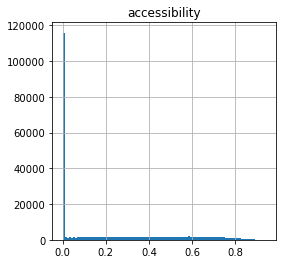

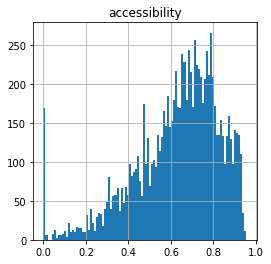

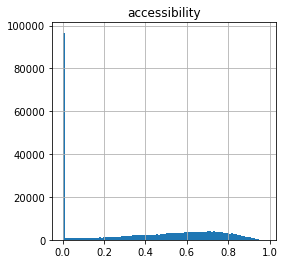

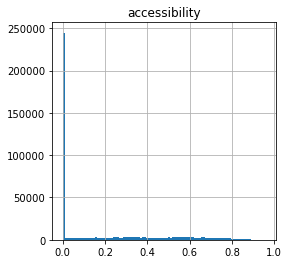

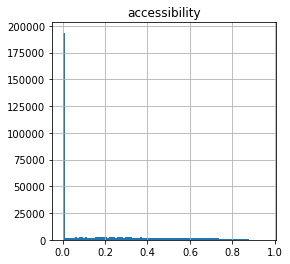

In [14]:
# The accessibility does not depend on the
# route_type columns of pt_los, but on the link path
pt.groupby('route_type').hist(column='accessibility', bins=100, figsize=(4,4), log=False)

In [15]:
sm.pt_los = pt.append(walk)

## Save

In [16]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|██████████████████████████████████████████████████████████████████| 35/35 [00:41<00:00,  1.19s/it]
